In [1]:
import numpy as np
import glob
from astropy.io import fits
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

In [2]:
name = "/Users/vpereir1/Desktop/SynCOM_project/data/STEREO_data/*.fts"

In [3]:
# data ingestion: loading data from FITS files into a 3D Numpy array

class DataIngestion:
    def __init__(self,file_pattern):
        self.file_pattern = file_pattern
        
    def load_data(self):
        try:
            # Find all FITS files matching the pattern 
            file_list = sorted(glob.glob(self.file_pattern))
            if not file_list:
                raise FileNotFoundError(f"No files found matching {self.file_pattern}")
            
            # read the first file to get the shape
            with fits.open(file_list[0]) as hdul:
                first_img = hdul[0].data
            nx, ny = first_img.shape # note in Python, shape is (rows, cols), IDL was (cols, rows)
            nt = len(file_list)
            
            print(f"Data dimensions: nx={ny} (columns), ny={nx} (rows), nt={nt} (frames)")
            
            # load all FITS inot a 3D Numpy array (ny, nx, nt)
            data = np.zeros((nx,nt,ny), dtype=np.float64)
            for i, filename in enumerate(file_list):
                with fits.open(filename) as hdul:
                    img = hdul[0].data.astype(np.float64)
                    if img.shape != (nx, ny):
                        raise ValueError(f"File {filename} has shape {img.shape}, as expected ({nx},{ny})")
                    data[:,i,:] = img
            print(f"Data loaded sucessufully!")
            return data
        
        except Exception as e:
            print(f"Error loading data: {e}")
            return None

# COR2 = DataIngestion("/Users/vpereir1/Desktop/SynCOM_project/data/STEREO_data/*.fts")
# data = COR2.load_data()
# print(data.shape)

In [4]:
# data cleaning: fixing any bad pixel present in the dataset

class DataCleaning:
    def __init__(self,data):
        self.data = data
    
    def fix_bad_pixels(self,frame_index):
        """
        Fixes specific bad pixels using the average of their veritical neighbors
        """
        # Provided bad pixel coordinates
        bad_y_coords = [2712, 2718, 2724, 2726, 2728, 2729, 2735, 2737, 2738, 2739, 2740, 2741, 2893]
        bad_x_coords = [145] * len(bad_y_coords)  # All pixels are at y=145
        
        for x,y in zip(bad_x_coords, bad_y_coords):
            if (0 < y < self.data.shape[2] - 1) and (0 < frame_index < self.data.shape[1] - 1):
                # average vertical neighbors from frames (frame_index - 1) and (frame_index + 1)
                self.data[x, frame_index, y] = 0.5 * (self.data[x, frame_index - 1 , y - 1] + self.data[x, frame_index + 1 , y + 1])
                
        print(f"Fixed {len(bad_y_coords)} bad pixels in frame (frame_index).")
        return self.data
        
# data_fixed = DataCleaning(data)
# data = data_fixed.fix_bad_pixels(frame_index=339)
# print(data.shape)

In [5]:
# data transformation

class DataTransformation:
    def __init__(self,data):
        self.data = data
    
    def resample_data(self,target_ny):
        """
        Resamples data along the "ny" axis to the target's size
        """
        current_ny = self.data.shape[2]
        scale_factor = target_ny / current_ny
        
        # apply resampling using linear interpolation
        resampled_data = zoom(self.data, (1.0, 1.0, scale_factor), order=1)
        
        print(f"Resampled data from ny={current_ny} to ny={target_ny}")
        
        self.data = resampled_data
        return resampled_data
    
    def normalize_data(self):
        """
        Normalizes the data to the range [0,1]
        """
        min_val = np.min(self.data)
        max_val = np.max(self.data)
        
        if max_val - min_val == 0:
            print("Warning data has no variation; returning original data")
            return self.data
        
        normalized_data = (self.data - min_val) / (max_val - min_val)
        print("Data normalized to range 0 to 1. Min: {min_val}, Max: {max_val}")
        
        self.data = normalized_data
        return normalized_data
    
    def convert_data(self, convert=False):
        if convert: 
            converted_data = np.transpose(self.data, (0,2,1)) # from (nx,nt,ny) to (nx,ny,nt)
            
            print("Data converted from (nx,nt,ny) to (nx,ny,nt)")
            self.data = converted_data
            return converted_data
        else:
            print("Conversion skipped (convert=False)")
            return self.data

# transform = DataTransformation(data)
# data = transform.normalize_data()
# data = transform.convert_data(convert=True)
# min_val = np.min(data)
# max_val = np.max(data)

# print(min_val,max_val)
# print(data.shape)

In [6]:
# save clean data

class DataOutput:
    def __init__(self, data):
        self.data = data

    def save_as_npy(self, filename):
        """
        Saves the processed data as a NumPy binary (.npy) file.
        """
        np.save(filename, self.data)
        print(f"Data saved as NumPy file: {filename}")

In [11]:
# data visualization

class DataVisualization:
    def __init__(self,data,r0=5.0,dr=0.014,angular_range=(0,360),time_step=300):
        self.data = data
        self.r0 = r0
        self.dr = dr
        self.angular_range = angular_range
        self.time_step = time_step
    
    def plot_polar_image(self,slice_index,cmap):
        """
        Visualizes a polar image from the data cube by fixing the time index (nt)
        """
        if slice_index >= self.data.shape[2]:
            raise ValueError(f"slice_index={slice_index} exceeds data's nt dimensions")
        
        image_slice = self.data[:,slice_index,:] # shape (nx,ny)
        
#         # axis conversion
#         ny = image_slice.shape[1]
#         nx = image_slice.shape[0]
#         radial_distance = self.r0 + np.arange(ny) * self.dr
#         angular_positions = np.arange(nx)
#         print(ny,radial_distance[0], radial_distance[-1], self.dr)
#         print(nx,angular_positions[0], angular_positions[-1])
        
        plt.figure(figsize=(12,4))
        plt.imshow(image_slice, origin='lower', cmap=cmap, aspect='auto')
        plt.colorbar(label='Intensity')
        plt.title(f"Slice at t={slice_index}")
        plt.xlabel("Position angle (degrees)")
        plt.ylabel("Radial distance (R_sun)")
        plt.show()
        
    def plot_distance_time(self,slice_index,cmap):
        """.
        Visualizes a distance-time plot by fixing the angular position (nx)
        """
        if slice_index >= self.data.shape[0]:
            raise ValueError(f"slice_index={slice_index} exceeds data's nt dimensions")
        
        image_slice = self.data[:,:,slice_index] # shape (nt,ny)
#         print(self.data.shape)
        
#         # axis conversion
#         ny = image_slice.shape[1]
#         nt = image_slice.shape[0]
#         radial_distance = self.r0 + np.arange(ny) * self.dr
#         time_axis = np.arange(nt) * self.time_step/3600
        
        plt.figure(figsize=(12,4))
        plt.imshow(image_slice, origin='lower', cmap=cmap, aspect='auto')
        plt.colorbar(label='Intensity')
        plt.title(f"Slice at t={slice_index}")
        plt.xlabel("Time step (seconds)")
        plt.ylabel("Radial distance (R_sun)")
        plt.show()

In [13]:
# using data pipeline

# Step 1: Load Data
ingestion = DataIngestion(name)
data = ingestion.load_data()

# Step 2: Fix Bad Pixels
cleaning = DataCleaning(data)
cleaned_data = cleaning.fix_bad_pixels(frame_index=339)

# Step 3: Resample Data
transformation = DataTransformation(cleaned_data)
# resampled_data = transformation.resample_data(target_ny=360)
normalized_data = DataTransformation(cleaned_data).normalize_data()
converted_data = DataTransformation(normalized_data).convert_data()

# Step 4: Save Data
name_output = 'processed_data.npy'

output = DataOutput(converted_data)
output.save_as_npy(name_output)  

# Step 5: Visualize Data with Physical Axis Labels
# Example: r0 = 5 R☉, dr = 0.014 R☉/pixel, angular range 0°–360°, 12 seconds per frame
visualization = DataVisualization(data, r0=5, dr=0.014, angular_range=(0, 360), time_step=300)

Data dimensions: nx=3600 (columns), ny=659 (rows), nt=848 (frames)
Data loaded sucessufully!
Fixed 13 bad pixels in frame (frame_index).
Data normalized to range 0 to 1. Min: {min_val}, Max: {max_val}
Conversion skipped (convert=False)
✅ Data saved as NumPy file: processed_data.npy


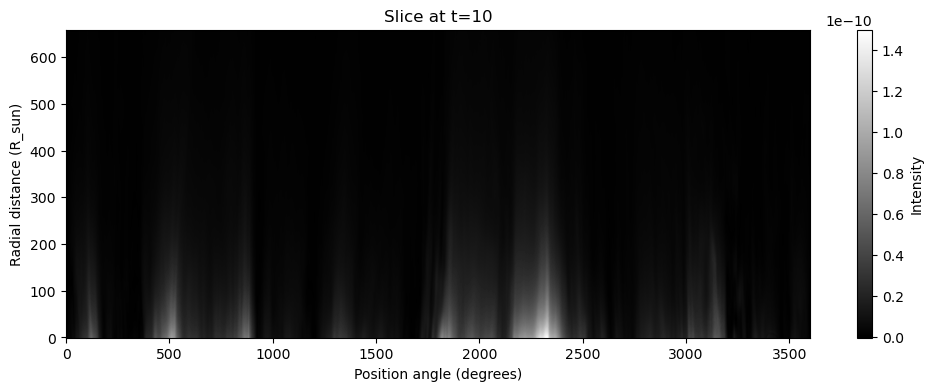

In [14]:
# Plot Polar Image
visualization.plot_polar_image(slice_index=10,cmap='gray')


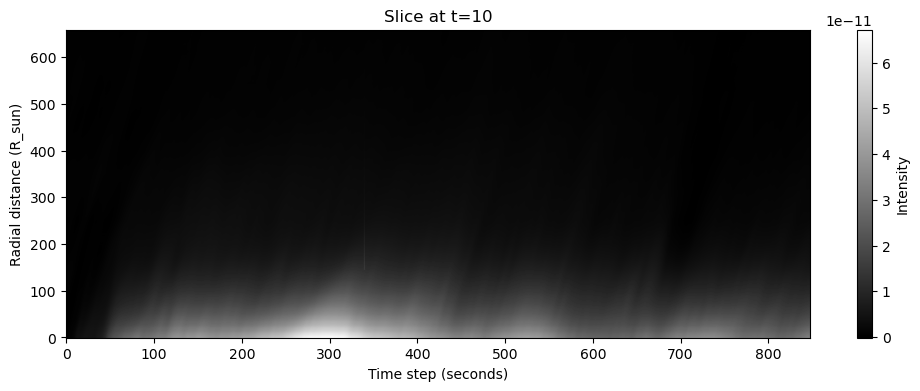

In [15]:
# Plot Distance-Time Plot
visualization.plot_distance_time(slice_index=10,cmap='gray')